In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import re
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pyproj
from pyproj import Transformer
from shapely.geometry import Polygon, Point

import warnings
warnings.filterwarnings("ignore")

#### <center>1. Загрузите датасет taxi.csv

In [2]:
data = pd.read_csv('taxi.csv')

In [3]:
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [4]:
data.shape

(100000, 14)

#### <center>2. Посмотрите на данные. Отобразите общую информацию по признакам (вспомните о describe и info). Напишите в markdown свои наблюдения

In [5]:
data.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.662189e+05,3.159860,13.827790,3446.376360,460867.01291,55.700824,37.492292,55.772440,37.541637,18.393518,23.134841,0.492480
std,3.259360e+05,2.054222,7.306496,2038.738677,266064.98953,2.135903,1.454640,0.665985,0.467758,41.129296,33.890105,0.499946
min,4.000000e+00,0.000000,0.000000,14.000000,18.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.855552e+05,1.000000,8.000000,1421.000000,229178.50000,55.708651,37.413497,55.708032,37.407117,-1.000000,-1.000000,0.000000
50%,5.656715e+05,3.000000,16.000000,3506.500000,462420.00000,55.772904,37.533664,55.772561,37.532537,10.411500,19.700000,0.000000
75%,8.487198e+05,5.000000,20.000000,5242.000000,690894.00000,55.960667,37.624113,55.962000,37.624358,30.665250,37.867000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.00000,56.174097,38.280547,56.311121,38.243608,5234.283000,3958.283000,1.000000


In [6]:
data.describe(include = 'object')

,offer_class_group,ride_type_desc
count,100000,100000
unique,9,4
top,Economy,private
freq,48335,91207


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   offer_gk                100000 non-null  int64  
 1   weekday_key             100000 non-null  int64  
 2   hour_key                100000 non-null  int64  
 3   driver_gk               100000 non-null  int64  
 4   order_gk                100000 non-null  int64  
 5   driver_latitude         100000 non-null  float64
 6   driver_longitude        100000 non-null  float64
 7   origin_order_latitude   100000 non-null  float64
 8   origin_order_longitude  100000 non-null  float64
 9   distance_km             100000 non-null  float64
 10  duration_min            100000 non-null  float64
 11  offer_class_group       100000 non-null  object 
 12  ride_type_desc          100000 non-null  object 
 13  driver_response         100000 non-null  int64  
dtypes: float64(6), int64(

Наблюдения:
1. offer_gk - номер заказа, числовая переменная, пропущенных значений нет. Первый кандидат на удаление (особой информативности нет). Можно проверить, сколько уникальных значений.

In [8]:
len(data.offer_gk.unique())

100000

Все значения уникальные.

2. weekday_key - номер дня недели, числовая переменная.

In [9]:
data.weekday_key.value_counts()

5    19284
6    15466
0    14411
4    13290
1    13089
2    12859
3    11601
Name: weekday_key, dtype: int64

Предположительно, 0 - это понедельник, 6 - воскресенье. Получается, что наибольшее количесвто заказов было в субботу.  
Пропущенных значений нет.

3. hour_key - номер часа, числовая переменная.

In [10]:
data.hour_key.value_counts()

23    8184
21    7398
22    6881
0     6646
20    6566
19    6369
18    5889
17    5028
16    4500
15    4249
14    3584
8     3550
1     3467
13    3355
9     3298
12    3169
11    2890
10    2840
7     2482
2     2275
4     2193
5     1809
3     1768
6     1610
Name: hour_key, dtype: int64

Больше всего заказов - в ночное время. Пропущенных знаечний нет.

4. order_gk - номер заказа (еще один), числовая переменная, пропущенных значений нет. Второй кандидат на удаление (особой информативности нет).

In [11]:
data.order_gk.value_counts()

853342    14
714527    13
761031    13
828548    12
180487    12
          ..
529767     1
361705     1
57063      1
782999     1
786432     1
Name: order_gk, Length: 81435, dtype: int64

In [12]:
data[data.order_gk == 853342]

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
23218,929594,5,23,4339,853342,55.966694,37.415752,55.962322,37.407117,7.718,16.7,Economy,private,0
23484,574355,5,23,801,853342,55.961051,37.415866,55.962322,37.407117,7.718,16.7,Economy,private,0
23651,394516,5,23,2236,853342,55.962323,37.407117,55.962322,37.407117,7.718,16.7,Economy,private,0
24326,609443,5,23,4600,853342,55.962324,37.407116,55.962322,37.407117,7.718,16.7,Economy,private,0
24651,726807,5,23,4804,853342,55.960693,37.415349,55.962322,37.407117,7.718,16.7,Economy,private,0
24926,1066357,5,23,4100,853342,55.961092,37.413188,55.962322,37.407117,7.718,16.7,Economy,private,0
25672,338185,5,23,1793,853342,55.962122,37.409464,55.962322,37.407117,7.718,16.7,Economy,private,0
26857,882098,5,23,668,853342,55.962427,37.409279,55.962322,37.407117,7.718,16.7,Economy,private,0
27009,937263,5,23,2381,853342,55.961857,37.414049,55.962322,37.407117,7.718,16.7,Economy,private,0
27502,16487,5,23,1060,853342,55.961859,37.407126,55.962322,37.407117,7.718,16.7,Economy,private,0


Интересно отметить, что в order_gk присутсвуют повторяющиеся значения. Можно предположить, что order_gk - это номер заказа от пассажира (он изъявил желание куда-то уехать), а offer_gk - это номер заказа для водителя (согласится он брать этого пассажира или нет.

5. driver_latitude - широта места, где располагается водитель, числовая переменная. Пропущенные значения есть (-1).

In [13]:
data[data.driver_latitude == -1].shape

(140, 14)

Всего в наборе 100 000 записей, пропущенных значений в переменной driver_latitude - 140. Не так много. Можно удалить.

6. driver_longitude - долгота места, где располагается водитель, числовая переменная. Пропущенные значения есть (-1).

In [14]:
data[data.driver_longitude == -1].shape

(140, 14)

Пропущенные значения можно удалить.

7. origin_order_latitude - широта начального пункта маршрута, числовая переменная. Пропущенные значения есть (-1).

In [15]:
data[data.origin_order_latitude == -1].shape

(13, 14)

Пропущенные значения можно удалить.

8. origin_order_longitude - долгота начального пункта маршрута, числовая переменная. Пропущенные значения есть (-1).

In [16]:
data[data.origin_order_longitude == -1].shape

(13, 14)

Пропущенные значения можно удалить.

9. distance_km - дистанция, в км., числовая переменная. Есть пропущенные значения.

In [17]:
data[data.distance_km == -1].shape

(26207, 14)

Много пропущенных значений. Что с ними делать -- пока не понятно...  
Максимальное значение -- вызывает сомнения.

10. duration_min - продолжительность поездки, в мин., числовая переменная. Есть пропущенные значения.

In [18]:
data[data.duration_min == -1].shape

(26207, 14)

Много пропущенных значений. Что с ними делать -- пока не понятно...  
Максимальное значение -- вызывает сомнения.

10. offer_class_group - класс поездки, категориальная переменная (9 уровней). Пропущенных значений нет.

In [19]:
data.offer_class_group.value_counts()

Economy     48335
Standard    47288
Premium      1773
Delivery     1290
Kids          588
XL            464
VIP           225
VIP+           29
Test            8
Name: offer_class_group, dtype: int64

11. ride_type_desc - предположительно - перевозчик, категориальная переменная. Пропущенных значений нет.

In [20]:
data.ride_type_desc.value_counts()

private      91207
business      8533
affiliate      224
SMB             36
Name: ride_type_desc, dtype: int64

12. driver_response - решение водителя: брать заказ или нет, булева переменная. Пропущенных значений нет.

#### <center>3. Решения для пропущенных и сомнительных значений

Построим диаграмму размаха для переменной distance_km:

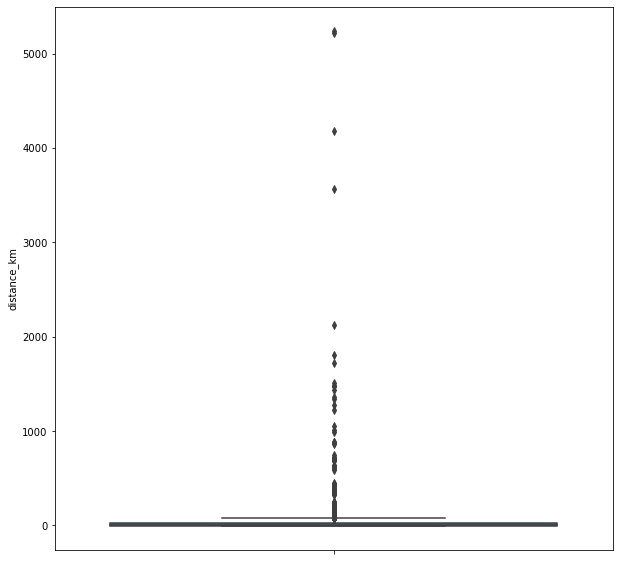

In [21]:
plt.rcParams['figure.figsize'] = (10,10)
ax = sns.boxplot(y = 'distance_km', data = data)

ax.set_xlabel('', fontsize = 10)
ax.set_ylabel('distance_km', fontsize = 10)
ax.tick_params(labelsize = 10)
plt.show()

5000 км - сомнительная дистанция. Попробуем определить город, по которому собраны данные. По широте и долготе было определено, что данные собраны по России (Москве)...

Построим гистограмму:

<AxesSubplot:>

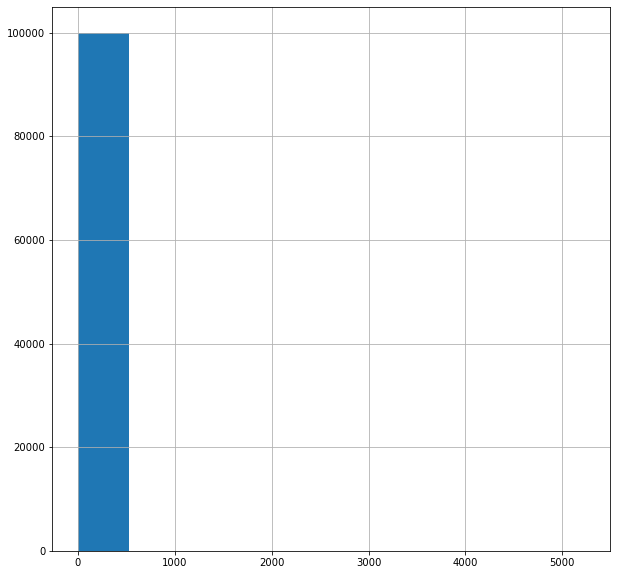

In [22]:
data.distance_km.hist(bins = 10)

Средний диаметр МКАД - 36 км, ЦКАД находится на расстоянии 50 км от МКАД, следовательно, будем считать, что дальность поездки заказов в пределах города не могут превышать 160 км. Отфильтруем данные.

In [23]:
data[data.distance_km > 160].shape

(75, 14)

Данных не так много, поэтому целесообразно их удалить.

In [24]:
data = data[data.distance_km <= 160]

In [25]:
data.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,9.992500e+04,99925.000000,99925.00000,99925.000000,99925.000000,99925.000000,99925.000000,99925.000000,99925.000000,99925.000000,99925.000000,99925.000000
mean,5.662353e+05,3.159480,13.82697,3446.234556,460867.680560,55.700847,37.492180,55.772518,37.541561,17.757299,22.658336,0.492329
std,3.259377e+05,2.054282,7.30722,2038.724365,266056.473936,2.136699,1.455170,0.666212,0.467893,20.270671,20.760357,0.499944
min,4.000000e+00,0.000000,0.00000,14.000000,18.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.855610e+05,1.000000,8.00000,1421.000000,229181.000000,55.708711,37.413497,55.708127,37.407117,-1.000000,-1.000000,0.000000
50%,5.657090e+05,3.000000,16.00000,3507.000000,462420.000000,55.772948,37.533589,55.772562,37.532490,10.395000,19.683000,0.000000
75%,8.487470e+05,5.000000,20.00000,5242.000000,690894.000000,55.960690,37.624055,55.962020,37.624326,30.585000,37.817000,1.000000
max,1.130355e+06,6.000000,23.00000,6806.000000,920344.000000,56.174097,38.280547,56.311121,38.243608,154.399000,139.500000,1.000000


Максимальное значение у переменной duration_min после удаления длительных поездок стало адекватным (чуть больше 2 часов).

Удалим значения -1 у следующих переменных:

In [26]:
data = data[data.driver_latitude != -1]

In [27]:
data = data[data.driver_longitude != -1]

In [28]:
data = data[data.origin_order_latitude != -1]

In [29]:
data = data[data.origin_order_longitude != -1]

In [30]:
data = data[data.distance_km != -1]

In [31]:
data = data[data.duration_min != -1]

In [32]:
data.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,7.368900e+04,73689.000000,73689.000000,73689.000000,73689.000000,73689.000000,73689.000000,73689.000000,73689.000000,73689.000000,73689.000000,73689.000000
mean,5.658031e+05,3.149751,13.799631,3461.226560,461945.906648,55.780157,37.545895,55.780255,37.546065,24.420378,31.064678,0.471400
std,3.262802e+05,2.078345,7.317082,2038.981905,266082.159956,0.258745,0.211650,0.159509,0.163001,19.676704,17.729262,0.499185
min,4.000000e+00,0.000000,0.000000,14.000000,27.000000,0.000000,0.000000,55.342523,36.994072,0.000000,0.000000,0.000000
25%,2.849050e+05,1.000000,8.000000,1421.000000,230773.000000,55.705900,37.413468,55.705657,37.407117,7.894000,16.550000,0.000000
50%,5.648580e+05,3.000000,16.000000,3507.000000,463102.000000,55.774854,37.528298,55.775066,37.527187,18.580000,28.167000,0.000000
75%,8.496250e+05,5.000000,20.000000,5246.000000,692512.000000,55.961104,37.625582,55.962322,37.625333,38.679000,44.283000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.000000,56.018542,38.232760,56.025061,38.204119,154.399000,139.500000,1.000000


Остались нулевые значения, что тоже не хорошо. Удалим и их.

In [33]:
data = data[data.driver_latitude != 0]

In [34]:
data = data[data.driver_longitude != 0]

In [35]:
data = data[data.distance_km != 0]

In [36]:
data = data[data.duration_min != 0]

In [37]:
data.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,7.353600e+04,73536.000000,73536.000000,73536.00000,73536.000000,73536.000000,73536.000000,73536.000000,73536.000000,73536.000000,73536.000000,73536.000000
mean,5.657864e+05,3.149927,13.802858,3461.24913,461945.595599,55.780927,37.546340,55.780272,37.545998,24.470593,31.128558,0.471375
std,3.262987e+05,2.078241,7.315733,2039.32244,266101.714387,0.157251,0.160186,0.159514,0.162976,19.665654,17.691067,0.499183
min,4.000000e+00,0.000000,0.000000,14.00000,27.000000,55.367720,36.984771,55.342523,36.994072,0.005000,0.017000,0.000000
25%,2.848650e+05,1.000000,8.000000,1421.00000,230548.500000,55.705912,37.413468,55.705657,37.407117,7.955000,16.600000,0.000000
50%,5.648260e+05,3.000000,16.000000,3507.00000,463144.000000,55.774885,37.528224,55.775078,37.527116,18.630000,28.200000,0.000000
75%,8.496432e+05,5.000000,20.000000,5246.00000,692516.750000,55.961104,37.625532,55.962322,37.625295,38.716750,44.317000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.00000,920344.000000,56.018542,38.232760,56.025061,38.204119,154.399000,139.500000,1.000000


Остались до сих пор какие-то странные значения у переменных distance_km	 и duration_min.

Построим диаграмму размаха для переменной duration_min:

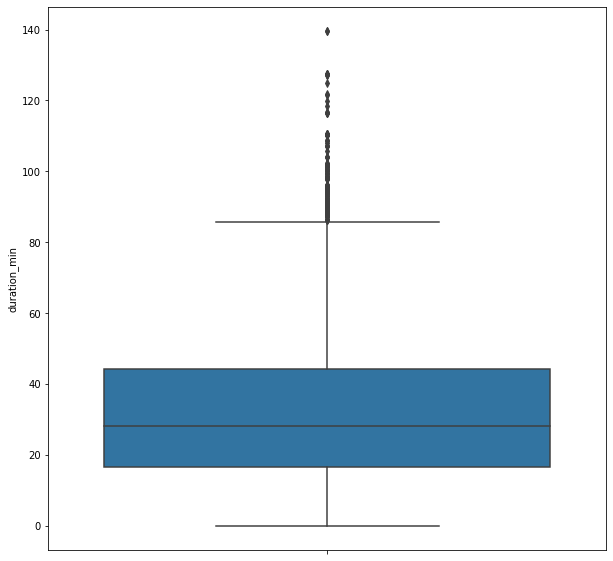

In [38]:
plt.rcParams['figure.figsize'] = (10,10)
ax = sns.boxplot(y = 'duration_min', data = data)

ax.set_xlabel('', fontsize = 10)
ax.set_ylabel('duration_min', fontsize = 10)
ax.tick_params(labelsize = 10)
plt.show()

In [39]:
data[data.duration_min < 2]

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
2058,760233,6,8,6792,411127,55.679458,37.284917,55.680331,37.295098,0.176,1.250,Standard,private,0
3409,487827,1,15,4269,542620,55.914972,37.868923,55.914829,37.869094,0.265,0.817,Standard,private,1
4660,876413,5,16,5187,752269,55.815405,37.706874,55.814097,37.717302,0.172,0.917,Economy,private,1
4752,784077,4,18,5187,870684,55.815605,37.706511,55.820014,37.707385,0.157,1.417,Standard,private,0
5636,458165,2,1,3842,857742,55.815721,37.341543,55.833015,37.347860,0.374,1.150,Economy,private,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87777,150386,5,8,6645,494585,55.685244,37.262108,55.669247,37.255974,0.893,1.850,Economy,private,0
88057,70371,3,17,6806,552410,55.680064,37.664809,55.682703,37.661768,0.139,0.867,Economy,private,0
92649,767295,4,19,4998,574206,55.799811,37.303643,55.804719,37.311626,0.056,0.133,Economy,private,0
93982,414446,2,17,4002,504611,55.892719,37.673594,55.886225,37.648417,0.393,1.967,Economy,private,1


Будем считать, что поездка не может длиться меньше 2 минут. Удалим странные значения.

In [40]:
data = data[data.duration_min >= 2]

In [41]:
data.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,7.347100e+04,73471.000000,73471.000000,73471.000000,73471.000000,73471.000000,73471.000000,73471.000000,73471.000000,73471.000000,73471.000000,73471.000000
mean,5.657926e+05,3.149773,13.804603,3460.718351,461929.217814,55.780926,37.546349,55.780271,37.546006,24.492011,31.155319,0.471274
std,3.263021e+05,2.078269,7.314928,2039.136489,266110.381224,0.157286,0.160196,0.159550,0.162986,19.661156,17.675978,0.499178
min,4.000000e+00,0.000000,0.000000,14.000000,27.000000,55.367720,36.984771,55.342523,36.994072,0.238000,2.000000,0.000000
25%,2.848640e+05,1.000000,8.000000,1421.000000,230544.000000,55.705917,37.413468,55.705657,37.407117,7.972000,16.633000,0.000000
50%,5.648310e+05,3.000000,16.000000,3507.000000,463039.000000,55.774893,37.528211,55.775078,37.527111,18.657000,28.217000,0.000000
75%,8.496550e+05,5.000000,20.000000,5246.000000,692512.000000,55.961106,37.625518,55.962322,37.625287,38.731000,44.333000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.000000,56.018542,38.232760,56.025061,38.204119,154.399000,139.500000,1.000000


In [42]:
data.shape

(73471, 14)

In [43]:
data = data.reset_index()

#### <center>4. Преобразование переменных: создание новых признаков

Немного географии и тригонометрии:

Законы сферической тригонометрии позволяют рассчитывать расстояния между точками, расположенными на сфере.

Кратчайшее расстояние между двумя точками на земной поверхности (если принять ее за сферу) определяется зависимостью:

cos(d) = sin(φА)·sin(φB) + cos(φА)·cos(φB)·cos(λА − λB),

где φА и φB — широты,  
λА, λB — долготы данных пунктов,   
d — расстояние между пунктами, измеряемое в радианах длиной дуги большого круга земного шара.

Расстояние между пунктами, измеряемое в километрах, определяется по формуле:

L = d·R,

где R = 6371 км — средний радиус земного шара.

Напишем функцию, которая будет определять расстояние от водителя до заказа по широте и долготе:

In [44]:
def det_distance(row):
    a_lat = row['driver_latitude'] * np.pi / 180
    b_lat = row['origin_order_latitude'] * np.pi / 180
    a_long = row['driver_longitude'] * np.pi / 180
    b_long = row['origin_order_longitude'] * np.pi / 180
    
    cos_d = np.sin(a_lat) * np.sin(b_lat) + np.cos(a_lat) * np.cos(b_lat) * np.cos((a_long - b_long)) 
    if cos_d < -1:
        cos_d = -1
    elif cos_d > 1:
        cos_d = 1
        
    distance = np.arccos(cos_d) * 6371
    
    return distance

In [45]:
data['distance'] = data.apply(det_distance, axis = 1)

In [46]:
data.head(3)

,index,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,distance
0,1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,3.413092
1,2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,0.409999
2,4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,1.062481


Попытка создать новую категориальную переменную, которая описывает округ, в котором располагался пассажир в начале поездки. Модель строилась с помощью метода k-средних.

In [47]:
# Описываем модель
model = KMeans(n_clusters = 10)

In [48]:
lat_long = data[['origin_order_latitude', 'origin_order_longitude']]

In [49]:
lat_long.head(3)

,origin_order_latitude,origin_order_longitude
0,55.819329,37.466398
1,55.814827,37.354074
2,55.812559,37.527407


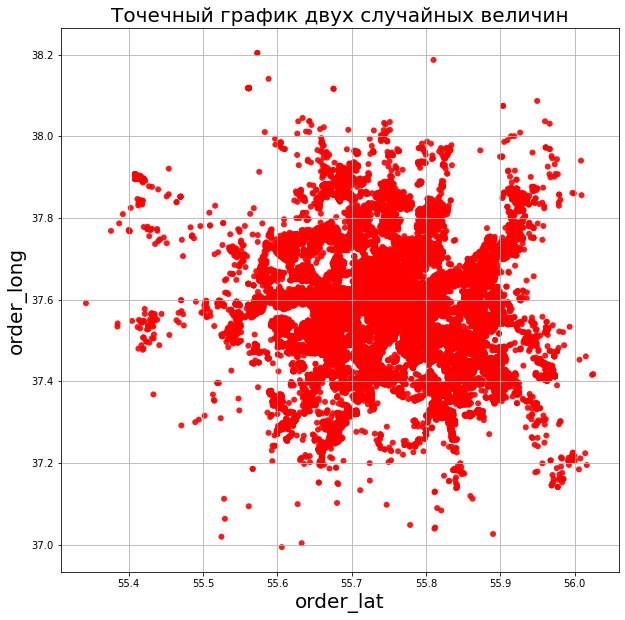

In [50]:
order_lat = data['origin_order_latitude']
order_long = data['origin_order_longitude']
fig, ax = plt.subplots()
ax.scatter(order_lat, order_long, c = 'red', alpha = 0.9, edgecolors = 'none')

ax.grid(True)
plt.xlabel('order_lat', fontsize = 20)
plt.ylabel('order_long', fontsize = 20)
plt.title('Точечный график двух случайных величин', fontsize = 20)
ax.tick_params(labelsize = 10)
plt.show()

In [51]:
# Проводим моделирование
model.fit(lat_long)

KMeans(n_clusters=10)

In [52]:
# Предсказание на всем наборе данных
district = model.predict(lat_long)

In [53]:
district = pd.DataFrame(district, columns = ['district'])

In [54]:
lat_long = lat_long.join(district)

In [55]:
lat_long.head(3)

,origin_order_latitude,origin_order_longitude,district
0,55.819329,37.466398,6
1,55.814827,37.354074,6
2,55.812559,37.527407,7


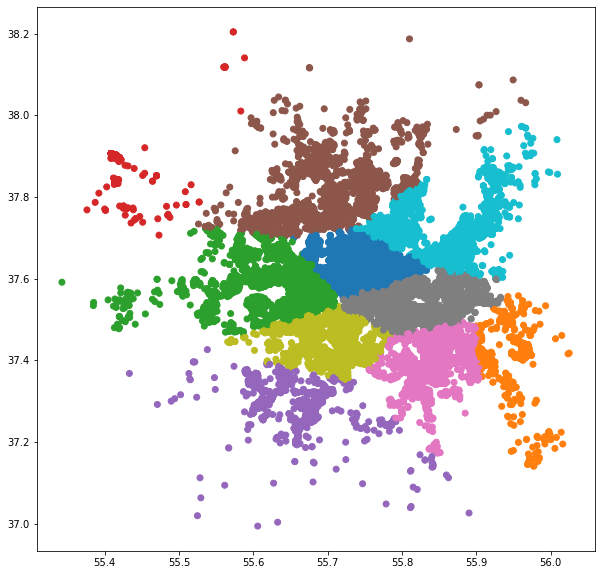

In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
x = lat_long['origin_order_latitude']
y = lat_long['origin_order_longitude']
label = lat_long['district']
plt.scatter(x, y, 
            c = label,
            cmap = mcolors.ListedColormap(['tab:blue', 'tab:orange', 
                                           'tab:green', 'tab:red', 
                                           'tab:purple', 'tab:brown', 
                                           'tab:pink', 'tab:gray', 
                                           'tab:olive', 'tab:cyan' ]))

Полученный результат кластеризации не совпадает с действительным делением Москвы на округа, тем не менее, целесообразно включение вновь созданной переменной в окончательный набор данных.

In [57]:
data = data.join(district)

In [58]:
data.head(3)

,index,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,distance,district
0,1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,3.413092,6
1,2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,0.409999,6
2,4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,1.062481,7


#### <center>5. Оцените зависимости переменных между собой. Используйте корреляции. Будет хорошо, если воспользуетесь profile_report. Напишите в markdown свои наблюдения

In [59]:
data_corr = data.corr()

<AxesSubplot:>

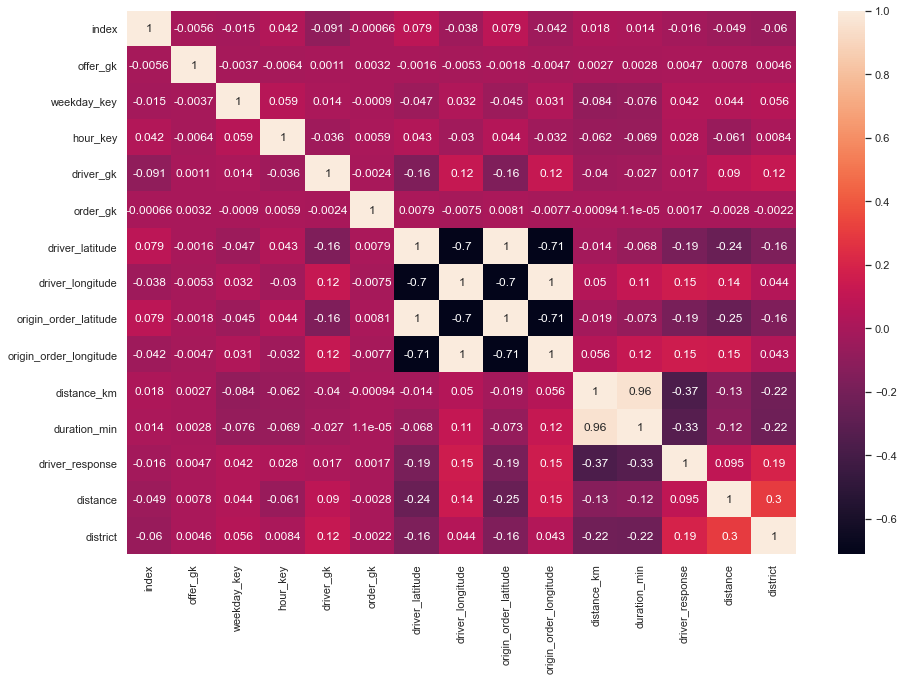

In [60]:
sns.set(rc = ({'figure.figsize':(15, 10)}))
sns.heatmap(data_corr, annot = True, 
            xticklabels = data_corr.columns.values, 
            yticklabels = data_corr.columns.values)

Наблюдается сильная обратная кореляция: решение водителя и расстояние и продолжительность поездки. Это вполне объяснимо. Также наблюдается сильная кореляция широты и долготы (как расположения водетиля, так и расположения пассажира).

Так как profile_report стал глючить, то без него...

#### <center> 6. Удаление лишних переменных

In [61]:
data.columns

Index(['index', 'offer_gk', 'weekday_key', 'hour_key', 'driver_gk', 'order_gk',
       'driver_latitude', 'driver_longitude', 'origin_order_latitude',
       'origin_order_longitude', 'distance_km', 'duration_min',
       'offer_class_group', 'ride_type_desc', 'driver_response', 'distance',
       'district'],
      dtype='object')

In [62]:
data_1 = data.drop(['index', 'offer_gk', 'driver_gk', 'order_gk', 'driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude'], axis = 1)

In [63]:
data_1.head(3)

,weekday_key,hour_key,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,distance,district
0,5,14,18.802,25.217,Standard,private,1,3.413092,6
1,6,14,6.747,9.800,Economy,private,0,0.409999,6
2,4,16,12.383,19.250,Economy,private,1,1.062481,7


#### <center> 7.Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей)

Преобразуем категориальные переменные. Будем использовать LabelEncoder:

In [64]:
label_enc = LabelEncoder()

Для переменной offer_class_group:

In [65]:
offer_class_group = label_enc.fit_transform(data_1['offer_class_group'])
offer_class_group = pd.DataFrame(offer_class_group, columns = ['offer_class_group'])

Для переменной ride_type_desc:

In [66]:
ride_type_desc = label_enc.fit_transform(data_1['ride_type_desc'])
ride_type_desc = pd.DataFrame(ride_type_desc, columns = ['ride_type_desc'])

Создадим новый dataframe, с которым будем работать:

In [67]:
new_data = data_1[['weekday_key', 'hour_key', 'distance_km', 'duration_min', 'driver_response', 'distance', 'district']]

Объединим преобразованные категориальные переменные с новым набором:

In [68]:
new_data = new_data.join(offer_class_group)
new_data = new_data.join(ride_type_desc)

In [69]:
new_data.head(3)

,weekday_key,hour_key,distance_km,duration_min,driver_response,distance,district,offer_class_group,ride_type_desc
0,5,14,18.802,25.217,1,3.413092,6,4,2
1,6,14,6.747,9.800,0,0.409999,6,1,2
2,4,16,12.383,19.250,1,1.062481,7,1,2


#### <center> 8. Разделите выборку на обучаемую и тестовую

In [70]:
X = new_data.drop(['driver_response'], axis = 1)

In [71]:
y = new_data.driver_response

In [72]:
ros = RandomOverSampler(random_state = 0)

ros.fit(X, y)
x_resampled, y_resampled = ros.fit_sample(X, y)
print('Количество элементов до операции:', len(X))
print('Количество элементов после операции:', len(x_resampled))

Количество элементов до операции: 73471
Количество элементов после операции: 77692


In [73]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size = 0.2)

#### <center> 9. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам

In [74]:
# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(x_train, y_train)

RandomForestClassifier()

Наиболее важные атрибуты для модели Random Forest:

No handles with labels found to put in legend.


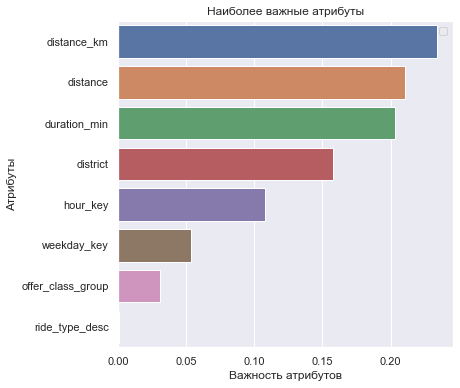

In [75]:
headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

Посчитаем качество модели - classification report:

In [76]:
model_pred = model.predict(x_test)

print(classification_report(y_test, model_pred))

model.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      7773
           1       0.74      0.83      0.78      7766

    accuracy                           0.77     15539
   macro avg       0.77      0.77      0.77     15539
weighted avg       0.77      0.77      0.77     15539



0.7707703198404016

Итоговый результат получился неплохим, но можно лучше.

#### <center> Попытка улучшить модель

Попробуем написать код, который будет позволять определять, к какому району Москвы относится кокретная точка на карте. Создадим новые переменные и еще раз построим модель.

In [77]:
areas = pd.read_csv('ao.csv')

In [78]:
areas.head(3)

,WKT,NAME,OKATO,ABBREV
0,"MULTIPOLYGON (((36.8031012 55.4408329,36.80319...",Троицкий,45298000,Троицкий
1,"MULTIPOLYGON (((37.0869749 55.5903604,37.09492...",Новомосковский,45297000,Новомосковский
2,"POLYGON ((37.1316021 56.0164459,37.1326592 56....",Зеленоградский,45272000,ЗелАО


Напишем код для преобразования угловых координат в координаты на плоскости:

In [88]:
districts = {}
for area in areas.iterrows():
        # Получение аббревиатуры административного округа
        abbrev = area[1].ABBREV
        # Получение границ административного округа. 
        # Границы могут быть представлены одним или несколькими многоугольниками
        polygons = area[1].WKT
        
        # Если рассматриваемый округ состоит из нескольких полигонов, то ...
        if 'MULTIPOLYGON' in polygons:
            # Регулярное выражение убирает слово 'MULTIPOLYGON', '((' и '))'
            m_polygon_pattern = r'(.*\(\()(\(.*\))(\)\).*)'
            right_m_polygon = re.sub(m_polygon_pattern, r'\2', polygons)
            # Разделяем на отдельные полигоны по фаблону '),('
            many_polygons = right_m_polygon.split('),(', maxsplit = -1)
            list_ = []
            
            for one_polygon in many_polygons:
                # Убираем открывающую и закрывающую скобки
                polygon = one_polygon[1 : -1]
                # Разделяемя отдельные точки полигона по запятой
                points = polygon.split(',', maxsplit = -1)
                points = pd.DataFrame(points, columns = ['points'])
                # Разделяемя широту и долготу по пробелу
                lat_lon_reg_exp = r'(\d+\.\d+)\s(\d+\.\d+)'
                lat_lon = points['points'].str.extract(lat_lon_reg_exp)
                lat_lon.columns = ['latitude', 'longitude']
                
                # Преобразование координат
                # WGS84 datum                                                               
                wgs84 = pyproj.Proj('EPSG:4326')
                # Albers Equal Area Conic (aea)                                             
                nplaea = pyproj.Proj("+proj=laea +lat_0=90 +lon_0=-40 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
                latitude = np.array(lat_lon['latitude'])
                longitude = np.array(lat_lon['longitude'])
                poly_x, poly_y = pyproj.transform(wgs84, nplaea, longitude, latitude)
                poly_proj = Polygon(zip(poly_x,poly_y))
                list_.append(poly_proj)
                
            districts[abbrev] = list_ 

        # Если Вы дочитали до этой строчки, то Вы большой МОЛОДЕЦ!
        # Если рассматриваемый округ состоит из одного полигона, то ...
        else:
            # Регулярное выражение убирает слово 'POLYGON', '(' и ')'
            polygon_pattern = r'(.*\()(\(.*\))(\).*)'
            right_polygon = re.sub(polygon_pattern, r'\2', polygons)
            list_ = []
            
            # Убираем открывающую и закрывающую скобки
            polygon = right_polygon[1 : -1]
            # Разделяемя отдельные точки полигона по запятой
            points = polygon.split(',', maxsplit = -1)
            points = pd.DataFrame(points, columns = ['points'])
            # Разделяемя широту и долготу по пробелу
            lat_lon_reg_exp = r'(\d+\.\d+)\s(\d+\.\d+)'
            lat_lon = points['points'].str.extract(lat_lon_reg_exp)
            lat_lon.columns = ['latitude', 'longitude']
            
            # Преобразование координат
            # WGS84 datum                                                               
            wgs84 = pyproj.Proj('EPSG:4326')
            # Albers Equal Area Conic (aea)                                             
            nplaea = pyproj.Proj("+proj=laea +lat_0=90 +lon_0=-40 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
            latitude = np.array(lat_lon['latitude'])
            longitude = np.array(lat_lon['longitude'])
            poly_x, poly_y = pyproj.transform(wgs84, nplaea, longitude, latitude)
            poly_proj = Polygon(zip(poly_x,poly_y))
            list_.append(poly_proj)
            
            districts[abbrev] = list_ 
print(districts)

{'Троицкий': [<shapely.geometry.polygon.Polygon object at 0x000002055D1E5708>, <shapely.geometry.polygon.Polygon object at 0x000002055E4A7D08>], 'Новомосковский': [<shapely.geometry.polygon.Polygon object at 0x000002055E38EAC8>, <shapely.geometry.polygon.Polygon object at 0x000002055E6E4E08>, <shapely.geometry.polygon.Polygon object at 0x000002055E34FA88>], 'ЗелАО': [<shapely.geometry.polygon.Polygon object at 0x000002055E6E2AC8>], 'ЮЗАО': [<shapely.geometry.polygon.Polygon object at 0x000002055BE423C8>], 'ЮВАО': [<shapely.geometry.polygon.Polygon object at 0x000002055E358F88>, <shapely.geometry.polygon.Polygon object at 0x000002055E34CAC8>], 'ЦАО': [<shapely.geometry.polygon.Polygon object at 0x000002055E4DF588>], 'САО': [<shapely.geometry.polygon.Polygon object at 0x000002055E38CFC8>, <shapely.geometry.polygon.Polygon object at 0x000002055E4CD3C8>], 'СЗАО': [<shapely.geometry.polygon.Polygon object at 0x000002055E364C08>], 'СВАО': [<shapely.geometry.polygon.Polygon object at 0x000002

Напишем вспомогательную функцию, которая для каждой строчки исходного dataframe по угловым координатм определяет район:

In [80]:
def get_district(latitude, longitude, districts):
    wgs84 = pyproj.Proj('EPSG:4326')  
    nnplaea = pyproj.Proj("+proj=laea +lat_0=90 +lon_0=-40 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    point_x, point_y = pyproj.transform(wgs84, nplaea, longitude, latitude)
    grid_point = Point(point_x, point_y)
    
    output = 'Неизвестно'
    
    for district in districts:
        items = districts[district]
        for item in items:
            if grid_point.within(item):
                output = district
                break
            
    return(output)

Напишем функцию, которая определяет район водителя:

In [81]:
def get_driver_district(row):
    driver_latitude = row['driver_latitude']
    driver_longitude = row['driver_longitude']
    driver_district = get_district(driver_longitude, driver_latitude, districts)
    return driver_district  

Напишем функцию, которая определяет район заказа:

In [83]:
def get_order_district(row):
    order_latitude = row['origin_order_latitude']
    order_longitude = row['origin_order_longitude']
    order_district = get_district(order_longitude, order_latitude, districts)
    return order_district

Создадим новые переменные в исходном dataframe: район водителя и район заказа

In [91]:
%%time
data['driver_district'] = data.apply(get_driver_district, axis = 1)

Wall time: 1h 15min 42s


In [92]:
%%time
data['order_district'] = data.apply(get_order_district, axis = 1)

Wall time: 1h 5min 12s


Напишем функцию, которая сравнивает район водителя и заказа. При их совпадении переменная равна 1, в обратнном случае - 0.

In [93]:
def compare_districts(row):
    driver_district = row.driver_district
    order_district = row.order_district
    if (driver_district == order_district) & ((driver_district != 'Неизвестно') | (order_district!= 'Неизвестно')):
        output = 1
    else:
        output = 0
    return(output)

Создадим новую переменную:

In [94]:
data['same_districts'] = data.apply(compare_districts, axis =1)

In [95]:
data.head(10)

,index,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,distance,district,driver_district,order_district,same_districts
0,1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,3.413092,6,САО,СЗАО,0
1,2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,0.409999,6,Неизвестно,Неизвестно,0
2,4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,1.062481,7,САО,САО,1
3,5,1058203,6,15,6080,360328,55.818963,37.361033,55.814827,37.354074,6.747,9.800,Economy,private,0,0.632868,6,Неизвестно,Неизвестно,0
4,7,128861,5,20,6080,254374,55.839318,37.248862,55.839134,37.304101,1.517,3.933,Economy,private,0,3.449065,6,Неизвестно,Неизвестно,0
5,8,493006,5,20,6080,753429,55.818748,37.338240,55.835764,37.294710,6.222,15.433,Economy,private,0,3.312348,6,Неизвестно,Неизвестно,0
6,9,953983,6,7,6080,533820,55.839155,37.251947,55.833198,37.312197,10.410,23.083,Economy,private,0,3.820042,6,Неизвестно,Неизвестно,0
7,10,479392,6,11,6080,139936,55.857133,37.414013,55.846374,37.362253,27.641,29.567,Economy,private,0,3.445132,6,СЗАО,СЗАО,1
8,11,976469,3,7,6080,620017,55.819520,37.322065,55.811627,37.363944,16.683,25.633,Economy,private,0,2.759704,6,Неизвестно,Неизвестно,0
9,12,139598,6,14,6080,279573,55.815298,37.350735,55.809279,37.325665,7.733,10.617,Economy,private,0,1.703394,6,Неизвестно,Неизвестно,0


Повторим шаги для создания модели. Удалим ненужные столбцы:

In [96]:
data_2 = data.drop(['index', 'offer_gk', 'driver_gk', 'order_gk', 'driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude'], axis = 1)

Преобразуем категориальные переменные:

In [97]:
label_enc = LabelEncoder()

Для переменной offer_class_group:

In [98]:
offer_class_group = label_enc.fit_transform(data_2['offer_class_group'])
offer_class_group = pd.DataFrame(offer_class_group, columns = ['offer_class_group'])

Для переменной ride_type_desc:

In [99]:
ride_type_desc = label_enc.fit_transform(data_2['ride_type_desc'])
ride_type_desc = pd.DataFrame(ride_type_desc, columns = ['ride_type_desc'])

Для переменной driver_district:

In [100]:
driver_district = label_enc.fit_transform(data_2['driver_district'])
driver_district = pd.DataFrame(driver_district, columns = ['driver_district'])

Для переменной order_district:

In [101]:
order_district = label_enc.fit_transform(data_2['order_district'])
order_district = pd.DataFrame(order_district, columns = ['order_district'])

Создадим итоговый набор данных:

In [102]:
final_data = data_2[['weekday_key', 'hour_key', 'distance_km', 'duration_min', 'driver_response', 'distance', 'same_districts']]

In [103]:
final_data = final_data.join(offer_class_group)
final_data = final_data.join(ride_type_desc)
final_data = final_data.join(driver_district)
final_data = final_data.join(order_district)
final_data = final_data.join(district)

In [104]:
final_data.head(3)

,weekday_key,hour_key,distance_km,duration_min,driver_response,distance,same_districts,offer_class_group,ride_type_desc,driver_district,order_district,district
0,5,14,18.802,25.217,1,3.413092,0,4,2,5,7,6
1,6,14,6.747,9.800,0,0.409999,0,1,2,3,3,6
2,4,16,12.383,19.250,1,1.062481,1,1,2,5,5,7


Разделим выборку на обучающую и тестовую:

In [105]:
X = final_data.drop(['driver_response'], axis = 1)

In [106]:
y = final_data.driver_response

In [107]:
ros = RandomOverSampler(random_state = 0)

ros.fit(X, y)
x_resampled, y_resampled = ros.fit_sample(X, y)
print('Количество элементов до операции:', len(X))
print('Количество элементов после операции:', len(x_resampled))

Количество элементов до операции: 73471
Количество элементов после операции: 77692


In [108]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size = 0.2)

Обучим модель:

In [109]:
# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(x_train, y_train)

RandomForestClassifier()

Наиболее важные атрибуты для модели Random Forest:

No handles with labels found to put in legend.


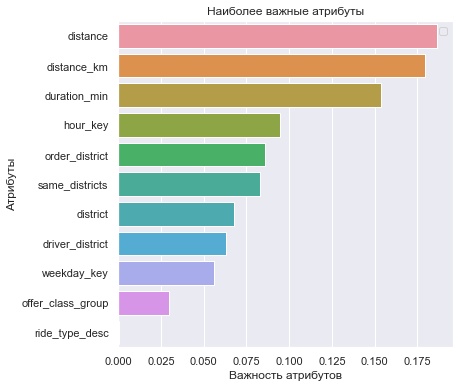

In [110]:
headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

Посчитаем качество модели - classification report:

In [111]:
model_pred = model.predict(x_test)

print(classification_report(y_test, model_pred))

model.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      7740
           1       0.75      0.84      0.79      7799

    accuracy                           0.78     15539
   macro avg       0.78      0.78      0.78     15539
weighted avg       0.78      0.78      0.78     15539



0.7768196151618508

К сожалению, качество модели не стало лучше. Тем не менее был получен интресный опыт работы с координатами и картами ;D